In [2]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();

  Activating project at `~/Documents/eth_courses/notebooks/control/MPC`


In [211]:
import Random
using LinearAlgebra
using ControlSystems

# SOlvers,
using SparseArrays, OSQP

# Utility function
speye(N) = spdiagm(ones(N))

using GLMakie
GLMakie.activate!(inline=true)

In [284]:
# Discrete dynamics
h = 0.1   # time step
Ad = [1 h;
    0 1]
Bd = [0.5*h*h;
    h]

nx = 2     # number of state
nu = 1     # number of controls

N = 10
t_vec = Array(range(0,h*(N), step=h));

# Initial conditions
x0 = [1.0; 0]

2-element Vector{Float64}:
 1.0
 0.0

In [285]:
function plot_result(t_vec, xhist, uhist)
    fig = Figure(resolution = (1000, 400))

    ax1 = Axis(fig[1, 1], title="States", xlabel = "time")
    ax2 = Axis(fig[1, 2], title="Control input", xlabel = "time")
    
    
    # t_vec = range(0,h*(N-1), step=h)
    lines!(ax1, t_vec ,xhist[1,:])
    
    lines!(ax1,t_vec,xhist[2,:])
    
    stem!(ax2, t_vec, uhist)
    display(fig)

end

plot_result (generic function with 1 method)

## Controller

## Objective

In [286]:
umin = [-5.0] 
umax = [5.0] 
xmin = [-10.,-10.]
xmax = [10.,10.]


2-element Vector{Float64}:
 10.0
 10.0

In [287]:
# Initial and reference states
x0 = [1.0, 0.]
xf = [4.0, 0.]

# - quadratic objective
Q_block = kron(speye(N), Q)
Qn_block = Qn
R_block= kron(speye(N), R)

P = blockdiag(Q_block, Qn_block, R_block);

# linear objective
q = [repeat(-Q * xf, N); -Qn * xf; zeros(N*nu)]

# - linear dynamics
Ax = kron(speye(N + 1), -speye(nx)) + kron(spdiagm(-1 => ones(N)), Ad)
Bu = kron([spzeros(1, N); speye(N)], Bd)
Aeq = [Ax Bu]
leq = [-x0; zeros(N * nx)]
ueq = leq

# - input and state constraints
Aineq = speye((N + 1) * nx + N * nu)
lineq = [repeat(xmin, N + 1); repeat(umin, N)]
uineq = [repeat(xmax, N + 1); repeat(umax, N)]

# - OSQP constraints
A, l, u = [Aeq; Aineq], [leq; lineq], [ueq; uineq];

## Solving

In [288]:
# Create an OSQP model
m = OSQP.Model()

# Setup workspace
OSQP.setup!(m; P=P, q=q, A=A, l=l, u=u, warm_starting=true, verbose=false)

# Solve
res = OSQP.solve!(m);
z_val= res.x; # This will always be a matrix

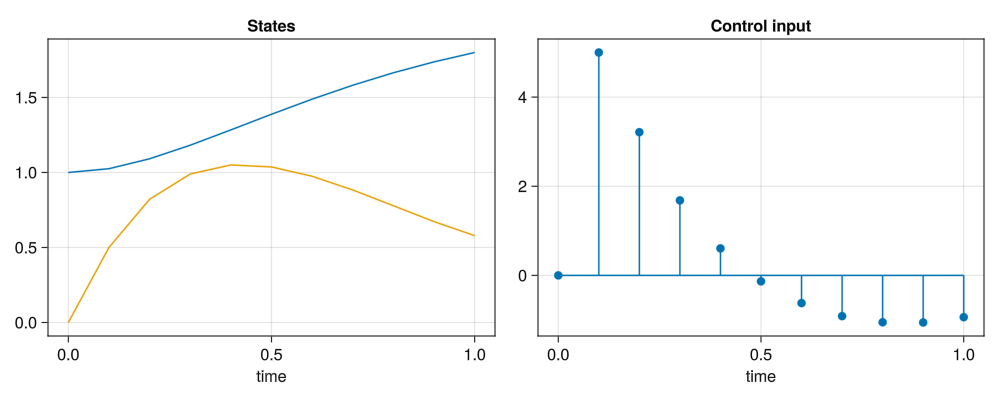

GLMakie.Screen(...)

In [289]:
xhist = z_val[1:nx*(N+1)]
xhist = reshape(xhist, nx,N+1)
# xhist = [x0 xhist]

# Get control history
uhist = z_val[nx*(N+1)+1:end];

# # append initial state and initial control input
uhist = [0; uhist]

plot_result(t_vec, xhist, uhist)

## Simulation with Receding horizon control

In [290]:
# Create state-space system
C       = [1 1]
sys     = ss(Ad,Bd,C,0,h)

function get_mpc_control(x0,m)
    OSQP.update!(m; l=l, u=u)
    
    res = OSQP.solve!(m);
    z_val= res.x; #

    # extract control input for first timestep
    uhist = z_val[nx*(N+1)+1:end];
    
    # Update initial state
    l[1:nx], u[1:nx] = -x0, -x0
    
    return uhist[1]
end

get_mpc_control (generic function with 2 methods)

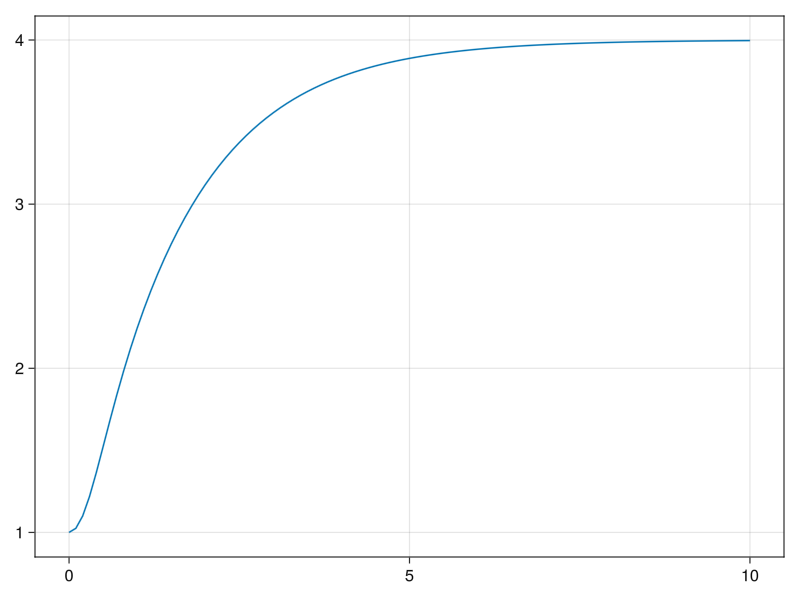

In [291]:
# Simulation
control_law(x,t)  = get_mpc_control(x,m);

t       = 0:h:10              # Time vector

y, t, x, uout = lsim(sys,control_law,t,x0=x0);

# plotting
lines(t, x[1, 1:end])